# Trajectory Optimization and Tracking Simulation

In this notebook, we will run the differential flatness planner and trajectory tracking code from Problem 2.

In [101]:
# The autoreload extension will automatically load in new code as you edit files, 
# so you don't need to restart the kernel every time
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
from utils import simulate_car_dyn, maybe_makedirs
from P2_differential_flatness import State, compute_traj_coeffs, compute_traj, compute_controls
from P2_trajectory_tracking import TrajectoryTracker

maybe_makedirs('plots')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Various constants
(Try changing these and seeing what happens)

In [102]:
V_max = 0.75 # max speed
om_max = 1 # max rotational speed
tf  = 25 # final time (sec)
N = 501 # number of timesteps
dt = tf*1./(N-1)

### Starting and Final States
(Try changing these and seeing what happens)

In [103]:
s_0 = State(x=0, y=0, V=0.5, th=-np.pi/2)
s_f = State(x=5, y=5, V=0.5, th=-np.pi/2)

# Trajectory Optimization
First, we will use the implementations from problem 2 to compute a dynamically feasible trajectory from the starting point to the goal.

In [104]:
coeffs = compute_traj_coeffs(s_0, s_f, tf)
t, traj = compute_traj(coeffs, tf, N)
V, om = compute_controls(traj)

(501,)


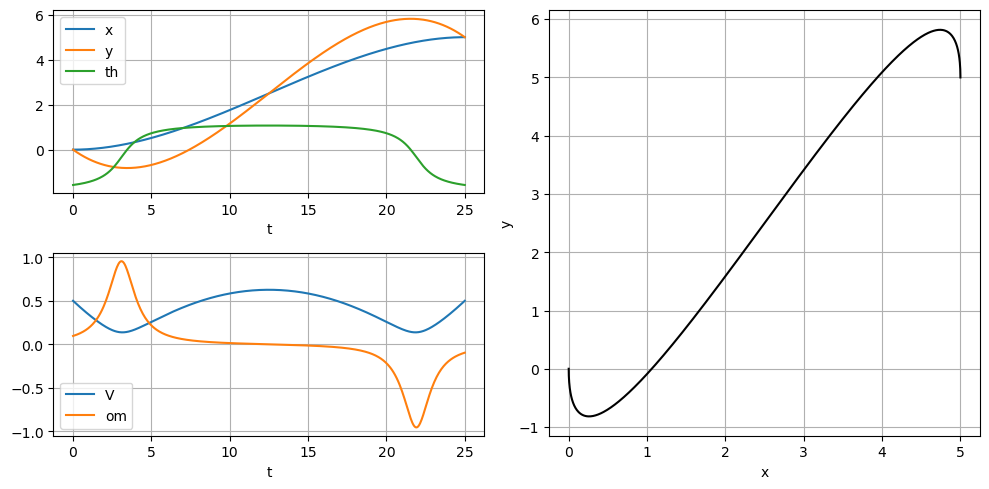

In [105]:
plt.figure(figsize=[10,5])
plt.subplot(2,2,1)
plt.plot(t, traj[:,:3])
plt.grid(True)
plt.xlabel('t')
plt.legend(labels=["x","y","th"])
plt.subplot(2,2,3)
plt.plot(t, V)
plt.plot(t, om)
plt.grid(True)
plt.xlabel('t')
plt.legend(labels=["V","om"])
plt.subplot(1,2,2)
plt.plot(traj[:,0], traj[:,1], color='k')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
plt.show()

# Simulation
Next, we will simulate how well we can actually execute these trajectories in the presense of noise. We will make use of the `simulate_car_dyn` function to do the simulation. Take a look in `utils.py` to see what it's doing under the hood.

In [106]:
print(simulate_car_dyn.__doc__)


    inputs: x_0,y_0,th_0 (floats) initial state
            times (list len N) sequence of times at which to apply control
            controller: controller object to use to compute feedback control
            actions: (np.array shape: N-1, 2) list of actions to apply
            noise_scale: (float) standard deviation of control noise

            if controller is provided, simulates feedback control by calling
                controller.compute_control(x,y,th,t) at each time step
            otherwise, if the array actions is specified, they are applied open loop

            (one of controller or actions must be specified)

    outputs: states (np.array shape (N, 3)) sequence of [x,y,th] state vectors
             ctrl (np.array shape (N-1, 2)) sequence of [V, om] control vectors
    


Choose a value of noise to apply at each step

In [107]:
noise_scale = np.sqrt(0.2)

## Open Loop
First, we simulate tracking this trajectory without any feedback control

In [108]:
actions_ol = np.stack([V, om], axis=-1)
states_ol, ctrl_ol = simulate_car_dyn(s_0.x, s_0.y, s_0.th, t, actions=actions_ol, noise_scale=noise_scale)

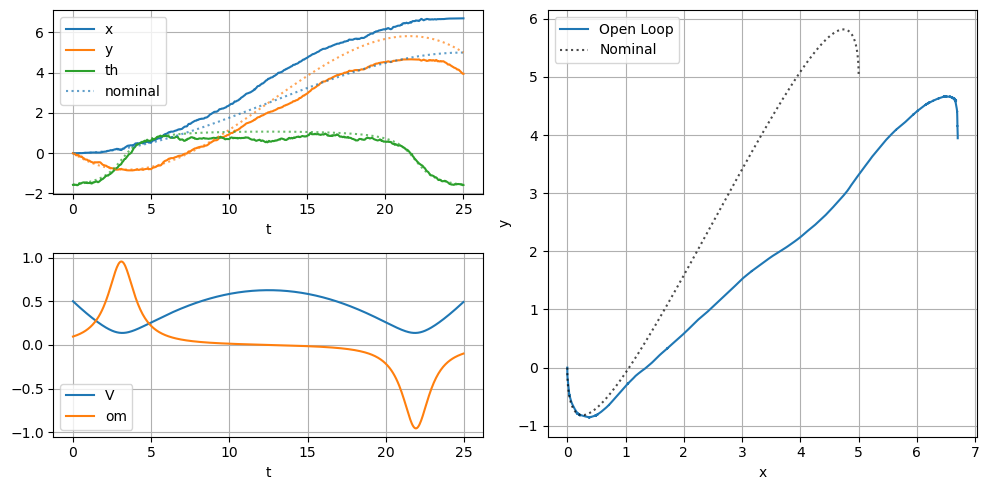

In [109]:
plt.figure(figsize=[10,5])
plt.subplot(2,2,1)
plt.plot(t, states_ol)
plt.plot(t, traj[:,0], linestyle=':', color='C0', alpha=0.7)
plt.plot(t, traj[:,1], linestyle=':', color='C1', alpha=0.7)
plt.plot(t, traj[:,2], linestyle=':', color='C2', alpha=0.7)
plt.grid(True)
plt.xlabel('t')
plt.legend(labels=["x","y","th","nominal"])
plt.subplot(2,2,3)
plt.plot(t[:-1], ctrl_ol)
plt.grid(True)
plt.xlabel('t')
plt.legend(labels=["V","om"])
plt.subplot(1,2,2)
plt.plot(states_ol[:,0], states_ol[:,1])
plt.plot(traj[:,0], traj[:,1], color="k", linestyle=":", alpha=0.7)
plt.legend(labels=["Open Loop", "Nominal"])
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/sim_traj_openloop.pdf")
plt.show()

## Closed Loop
Next, we will use the tracking controller developed in problem 2 to apply feedback and track the trajectory in the presence of noise.

Try playing with these gains to see the impact on performance

In [110]:
kpx = 2
kpy = 2
kdx = 2
kdy = 2
controller = TrajectoryTracker(kpx=kpx, kpy=kpy, kdx=kdx, kdy=kdy, V_max=V_max, om_max=om_max)

This controller designed to be similar to the controller module you'll use on the real robots for the final project. You can think of it as a module that will track whatever trajectory is given to it from another module (e.g. a planner module). So the first step is to load the controller with the trajectory we have planned

In [111]:
controller.load_traj(t, traj)

Then, we can simulate.

In [112]:
tf_actual = t[-1]
times_cl = np.arange(0, tf_actual, dt)
states_cl, ctrl_cl = simulate_car_dyn(s_0.x, s_0.y, s_0.th, times_cl, controller=controller, noise_scale=noise_scale)

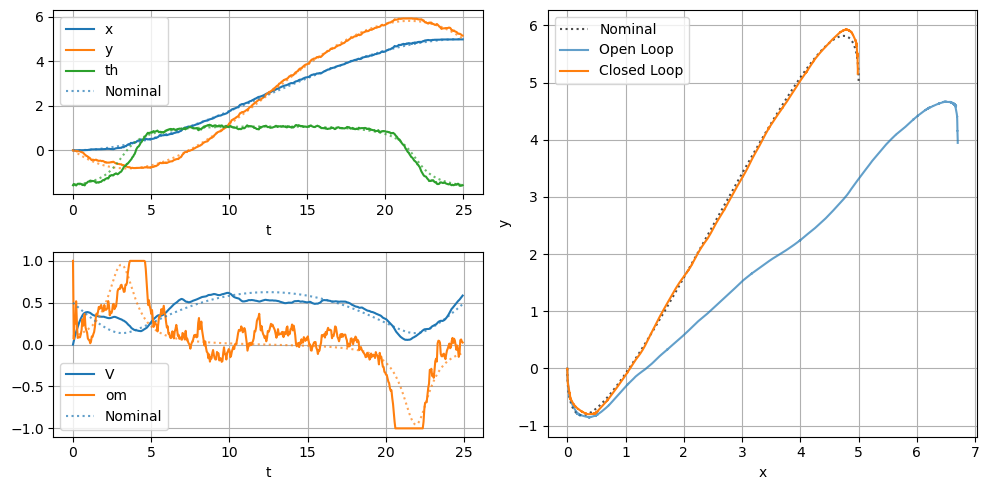

In [113]:
plt.figure(figsize=[10,5])
plt.subplot(2,2,1)
plt.plot(times_cl, states_cl)
plt.plot(t, traj[:,0], linestyle=':', color='C0', alpha=0.7)
plt.plot(t, traj[:,1], linestyle=':', color='C1', alpha=0.7)
plt.plot(t, traj[:,2], linestyle=':', color='C2', alpha=0.7)
plt.grid(True)
plt.xlabel('t')
plt.legend(labels=["x","y","th","Nominal"])
plt.subplot(2,2,3)
plt.plot(times_cl[:-1], ctrl_cl)
plt.plot(t[:-1], ctrl_ol[:,0], color='C0', linestyle=':', alpha=0.7)
plt.plot(t[:-1], ctrl_ol[:,1], color='C1', linestyle=':', alpha=0.7)
plt.grid(True)
plt.xlabel('t')
plt.legend(labels=["V","om", "Nominal"])
plt.subplot(1,2,2)
plt.plot(traj[:,0], traj[:,1], color="k", linestyle=":", alpha=0.7)
plt.plot(states_ol[:,0], states_ol[:,1], alpha=0.7)
plt.plot(states_cl[:,0], states_cl[:,1])
plt.legend(labels=["Nominal", "Open Loop", "Closed Loop"])
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/sim_traj_closedloop.pdf")
plt.show()